**CHATBOT**

In [1]:
!pip install langgraph langsmith

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 3.3 MB/s eta 0:00:00


In [2]:
!pip install langchain langchain_groq langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.8 MB/s eta 0:00:00


In [3]:
from google.colab import userdata
groq_api_key = userdata.get('Groq_API')
langsmith = userdata.get('LangSmith_API')

In [4]:
 import os
 os.environ['LANGCHAIN_TRACING_V2'] = 'true'
 os.environ['LANGCHAIN_PROJECT'] = "CHATBOT"
 os.environ['LANGCHAIN_API_KEY'] = langsmith

**Using LLM**

In [5]:
from langchain_groq import ChatGroq

In [6]:
llm=ChatGroq(groq_api_key=groq_api_key,model_name="llama3-8b-8192" )
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x79d0c583ea70>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x79d0c583edd0>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [7]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

In [8]:
class State(TypedDict):
  messages:Annotated[list, add_messages]


In [9]:
GraphBuilder=StateGraph(State)
GraphBuilder

In [10]:
def ChatBot(state:State):
  return{"messages":llm.invoke(state['messages'])}

In [11]:
GraphBuilder.add_node("ChatBot",ChatBot)
GraphBuilder

In [12]:
GraphBuilder.add_edge(START,"ChatBot")
GraphBuilder.add_edge("ChatBot",END)
GraphBuilder

In [13]:
graph=GraphBuilder.compile()

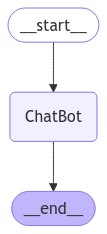

In [14]:
from IPython.display import Image, display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [15]:
"""
while True:
  print("Please type end when you're done")
  user_input=input("User: ")
  if user_input.lower() in ["end"]:
    print("Thank you for chatting. Talk to you later!")
    break
  for event in graph.stream({'messages':("user",user_input)}):
    print(event.values())
    for value in event.values():
      print(value['messages'])
      print("ChatBot:",value['messages'].content)
"""

'\nwhile True:\n  print("Please type end when you\'re done")\n  user_input=input("User: ")\n  if user_input.lower() in ["end"]:\n    print("Thank you for chatting. Talk to you later!")\n    break\n  for event in graph.stream({\'messages\':("user",user_input)}):\n    print(event.values())\n    for value in event.values():\n      print(value[\'messages\'])\n      print("ChatBot:",value[\'messages\'].content)\n'

**Using LLM and Tools**

In [16]:
!pip install arxiv wikipedia

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 4.3 MB/s eta 0:00:00
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11679 sha256=e2cb503fbe1189ad0034cf08fff097d479a50b95f0d5ed6c5ef4c204388573b1
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6047 sha256=9785bf2a37685ead571f7326a0ac152cecba77f5a23b2094ea731481739bfed2
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built wikipedia sgmllib3k


In [17]:
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

In [18]:
from langgraph.prebuilt import ToolNode,tools_condition

In [19]:
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=500)
arxiv_tool=ArxivQueryRun(api_wrapper=arxiv_wrapper)
wikipedia_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wikipedia_tool=WikipediaQueryRun(api_wrapper=wikipedia_wrapper)

In [20]:
wikipedia_tool.invoke("Who is MS Dhoni?")

'Page: MS Dhoni\nSummary: Mahendra Singh Dhoni ( ; born 7 July 1981) is an Indian professional cricketer who plays as a right-handed batter and a wicket-keeper. Widely regarded as one of the most prolific wicket-keeper batsmen and captains, he represented the Indian cricket team and was the captain of the side in limited overs formats from 2007 to 2017 and in test cricket from 2008 to 2014. Dhoni has captained the most international matches and is the most successful Indian captain. He has led Ind'

In [21]:
tool=[wikipedia_tool]

In [22]:
llm_with_tools=llm.bind(tools=tool)

In [23]:
GraphBuilderTools=StateGraph(State)
GraphBuilderTools

In [24]:
def ChatBot(state:State):
  return{"messages":llm_with_tools.invoke(state['messages'])}

In [25]:
GraphBuilderTools.add_node("ChatBot",ChatBot)
GraphBuilderTools

In [26]:
GraphBuilderTools.add_edge(START,"ChatBot")
tool_node=ToolNode(tools=tool)
GraphBuilderTools.add_node("tools",tool_node)
GraphBuilderTools.add_conditional_edges("ChatBot",tools_condition)
GraphBuilderTools.add_edge("tools","ChatBot")
GraphBuilderTools.add_edge("ChatBot",END)
GraphBuilderTools

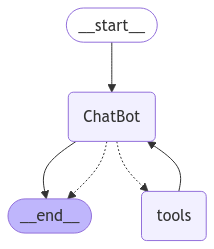

In [27]:
GraphBuilderTools.compile()

In [28]:
print("Please type end when you're done")
while True:
  user_input=input("User: ")
  if user_input.lower() in ["end"]:
    print("Thank you for chatting. Talk to you later!")
    break
  for event in graph.stream({'messages':("user",user_input)}):
    print(event.values())
    for value in event.values():
      print(value['messages'])
      print("ChatBot:",value['messages'].content)

Please type end when you're done
User: end
Thank you for chatting. Talk to you later!


**Front End Interface**

In [29]:
!git config --global user.email "AmithReddyKasarla@my.unt.edu"
!git config --global user.name "AmithReddyKasarla"

In [31]:
!git clone https://github.com/amithreddykasarla/ChatBot.git

Cloning into 'ChatBot'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.


In [32]:
%cd ChatBot
!git add .

/content/ChatBot


In [33]:
!git commit -m "Adding code to github"

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
